# SMS Spam Collection

Qëllimi i këtij projekti është të zhvillojmë dhe trajnojmë një model të mësimit të makinës që mund të diferencojë mesazhet e dëshiruara (ham) dhe ato të padëshiruara (spam) në një koleksion të madh të mesazheve SMS. Duke përdorur teknika të ndryshme të përpunimit të gjuhës natyrore dhe modele të mësimit të makinës, synojmë të arrijmë një saktësi të lartë në parashikimin e kategorisë së secilit mesazh. Kjo mundëson filtrimin efikas të mesazheve spam dhe përmirëson përvojën e përdoruesit duke minimizuar ndërhyrjet e padëshiruara. 

### Libraritë e përdorura

In [2]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Define input and output file paths
input_file = "SMSSpamCollection.csv"
output_file = "SMS_Spam_Collection.csv"

# Open input and output files
with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    # Create CSV writer
    writer = csv.writer(outfile)
    
    # Iterate over lines in the input file
    for line in infile:
        # Split line into label and message
        label, message = line.strip().split('\t')
        
        # Write label and message to CSV file
        writer.writerow([label, message])

print("Dataset successfully converted to CSV.")


Dataset successfully converted to CSV.


### Leximi i dataset-it

In [3]:
# Leximi i dataset-it
df = pd.read_csv("SMS_Spam_Collection.csv")

### Metodat ndihmëse

In [4]:
# Funksioni për të hedhur një vështrim në rreshtat e parë të dataset-it.
def printo_datasetin(text, df):
    print("\n" + text + ":")
    display(df.head())

## FAZA 1

### Kualiteti i të dhënave 

- Struktura e bazës së të dhënave

In [4]:
# Shfaqja e dataseti-it
printo_datasetin("Dataset-i", df)


Dataset-i:


,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


- Njohuri mbi llojet e të dhënave

In [5]:
# Për të fituar njohuri mbi llojet e të dhënave ekzekutojmë këtë komandë:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5574 non-null   object
 1   Message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


- Kontrollimi i vlerave null

In [6]:
# Komanda për kontrollimin e vlerave null:
df.isnull().sum()

Label      0
Message    0
dtype: int64

- Kërkimi i duplikatëve

In [7]:
# Komanda për kërkimin e duplikateve dhe shfaqja e rezultatit
print("Duplikatet: " + str(df.duplicated().sum()))

Duplikatet: 414


In [8]:
# ----------- Fshirja e duplikateve -----------
df.drop_duplicates(['Label', 'Message'], 
                   keep='first', inplace=True)

# Kërkimi përsëri i duplikateve dhe shfaqja e rezultatit
print("Duplikatet: " + str(df.duplicated().sum()))

Duplikatet: 0


### Trajnimi dhe testimi i të dhënave

In [9]:
# Përgatitja dhe pastrimi i të dhënave (nëse është e nevojshme)
df = df[['Label', 'Message']]
df.columns = ['Label', 'Message']

# Ndajmë të dhënat në trajnues dhe testim
X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Label'], test_size=0.2, random_state=42)

# Përdorimi i TF-IDF Vectorizer për të kthyer tekstet në një format të përpunueshëm numerik
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# Trajnojmë modelin duke përdorur Naive Bayes
model = MultinomialNB()
model.fit(X_train_transformed, y_train)

# Parashikimi dhe vlerësimi i modelit
predictions = model.predict(X_test_transformed)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.9563953488372093
Confusion Matrix:
 [[916   0]
 [ 45  71]]
Classification Report:
               precision    recall  f1-score   support

         ham       0.95      1.00      0.98       916
        spam       1.00      0.61      0.76       116

    accuracy                           0.96      1032
   macro avg       0.98      0.81      0.87      1032
weighted avg       0.96      0.96      0.95      1032



### Logistic Regression

In [10]:
lr_model = LogisticRegression()
lr_model.fit(X_train_transformed, y_train)
lr_predictions = lr_model.predict(X_test_transformed)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))

Logistic Regression Accuracy: 0.9660852713178295


### Support Vector Machine (SVM)

In [11]:
svm_model = SVC()
svm_model.fit(X_train_transformed, y_train)
svm_predictions = svm_model.predict(X_test_transformed)
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

SVM Accuracy: 0.9757751937984496


### Decision Trees

In [12]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_transformed, y_train)
dt_predictions = dt_model.predict(X_test_transformed)
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_predictions))

Decision Tree Accuracy: 0.9418604651162791


## FAZA 2


### Exploratory Data Analysis (EDA)

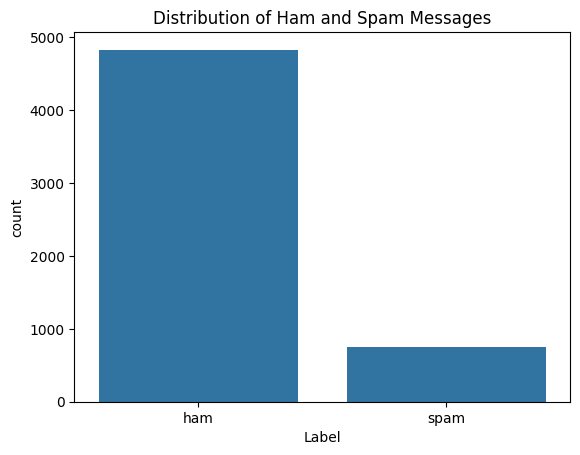

c:\Users\vlorasht\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\vlorasht\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\vlorasht\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = group

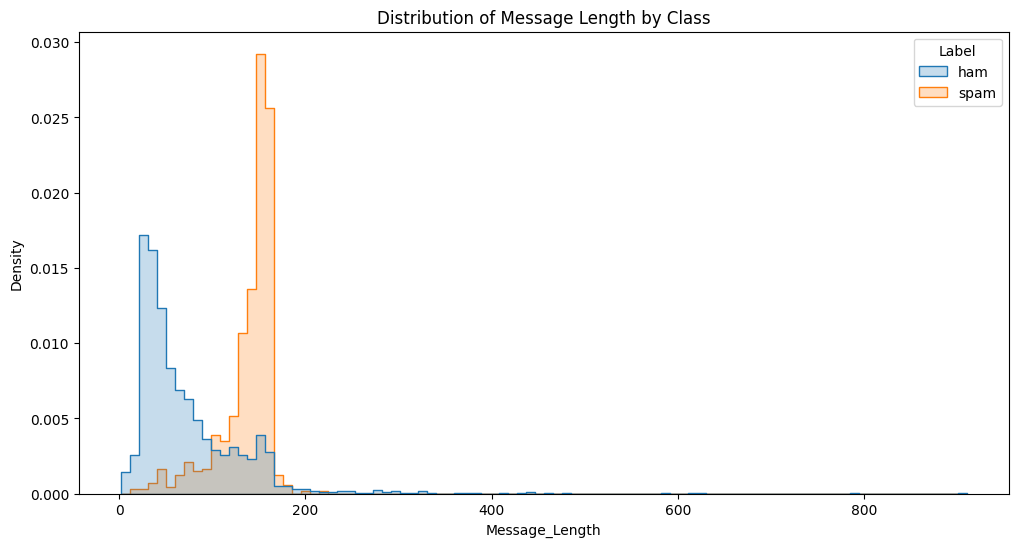

In [6]:
# Exploratory Data Analysis
## Class Distribution Visualization
sns.countplot(x='Label', data=df)
plt.title('Distribution of Ham and Spam Messages')
plt.show()

## Message Length Analysis
df['Message_Length'] = df['Message'].apply(len)
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=df, x='Message_Length', hue='Label', element='step', stat='density', common_norm=False)
ax.set_title('Distribution of Message Length by Class')
plt.show()

### Model Preparation and Explanation

In [7]:
# Data Preparation for Model Training
## Text Vectorization with TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Message'])
y = df['Label']

## Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training and Evaluation
## Train Naive Bayes Classifier
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9730941704035875
Confusion Matrix:
 [[954   0]
 [ 30 131]]
Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       954
        spam       1.00      0.81      0.90       161

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

